(dask-dataframe)=
# Dask DataFrame



## 创建 Dask DataFrame

使用 Dask 内置的方法创建一个名为 `ddf` 的 `DataFrame`，这份数据是随机生成的，每秒钟生成一个数据样本，共计 4 天（从 2024-01-01 0:00 至 2024-01-05 0:00）。

In [48]:
import dask

ddf = dask.datasets.timeseries(start="2024-01-01",
    end="2024-01-05")
ddf

,name,id,x,y
npartitions=4,,,,
2024-01-01,string,int64,float64,float64
2024-01-02,...,...,...,...
2024-01-03,...,...,...,...
2024-01-04,...,...,...,...
2024-01-05,...,...,...,...


pandas 所有操作是立即（Eager）执行的。Dask 是延迟（Lazy）执行的，数据并没有开始计算，所以都用省略号 ... 表示。

虽然 `ddf` 的数据还没有被计算，但 Dask 已经获取了数据的列名和数据类型，用 `dtypes` 查看列：

In [37]:
ddf.dtypes

name    string[pyarrow]
id                int64
x               float64
y               float64
dtype: object

## 执行计算

如果想计算并得到结果，必须使用 `compute()` 手动触发计算。

In [38]:
ddf.compute()

,name,id,x,y
timestamp,,,,
2024-01-01 00:00:00,Ursula,1010,-0.992705,-0.089483
2024-01-01 00:00:01,Yvonne,1007,0.594298,0.615315
2024-01-01 00:00:02,Yvonne,1026,-0.073250,0.334104
2024-01-01 00:00:03,Edith,977,-0.181292,0.597605
2024-01-01 00:00:04,Patricia,1013,0.462194,0.660002
...,...,...,...,...
2024-01-04 23:59:55,Tim,1035,-0.744785,0.334675
2024-01-04 23:59:56,Sarah,1033,0.288945,-0.010873
2024-01-04 23:59:57,Patricia,976,-0.601796,-0.704435


Dask DataFrame 有一个重要的内置变量 `npartitions`，它表示将数据切分成了多少份，或者说一共有多少个分区（Partition）。如 {numref}`dask-dataframe-partition` 所示，Dask DataFrame 是由多个 pandas DataFrame 组成的，每个 pandas DataFrame 又被称作一个 Partition。

In [39]:
ddf.npartitions

4

```{figure} ../img/ch-dask/dask-dataframe.svg
---
width: 400px
name: dask-dataframe-partition
---
Dask DataFrame 是由多个 pandas DataFrame 组成
```

每个 Partition 有上界和下界。这个例子中 `ddf` 是根据时间列进行的切分，每天的数据组成一个 Partition。内置变量 `divisions` 存放着每个 Partition 的分界线：

In [40]:
ddf.divisions

(Timestamp('2024-01-01 00:00:00'),
 Timestamp('2024-01-02 00:00:00'),
 Timestamp('2024-01-03 00:00:00'),
 Timestamp('2024-01-04 00:00:00'),
 Timestamp('2024-01-05 00:00:00'))

## 索引

:::{note}

pandas `DataFrame` 有一列专门存放索引（Index），Index 可以是数字，比如行号；也可以是时间。Index 列通常只用于索引，不作为数据字段，在 `ddf.dtypes` 中看不到 Index 列。

:::

本例中，`ddf` 的 Index 是时间。每个 Partition 基于 Index 列进行切分。整个 `ddf` 是四天的数据，每个 Partition 是一天的数据。

现在我们选择 2024-01-01 0:00 至 2024-01-02 5:00 的数据，横跨了两天，横跨了两个 Partition。

In [46]:
ddf["2024-01-01 0:00": "2024-01-02 5:00"]

,name,id,x,y
npartitions=2,,,,
2024-01-01 00:00:00.000000000,string,int64,float64,float64
2024-01-02 00:00:00.000000000,...,...,...,...
2024-01-02 05:00:59.999999999,...,...,...,...


还是需要使用 `compute()` 来触发计算，得到结果：

In [47]:
ddf["2024-01-01 0:00": "2024-01-02 5:00"].compute()

,name,id,x,y
timestamp,,,,
2024-01-01 00:00:00,Ursula,1010,-0.992705,-0.089483
2024-01-01 00:00:01,Yvonne,1007,0.594298,0.615315
2024-01-01 00:00:02,Yvonne,1026,-0.073250,0.334104
2024-01-01 00:00:03,Edith,977,-0.181292,0.597605
2024-01-01 00:00:04,Patricia,1013,0.462194,0.660002
...,...,...,...,...
2024-01-02 05:00:55,Wendy,980,-0.027608,-0.800858
2024-01-02 05:00:56,Sarah,929,0.939831,-0.499038
2024-01-02 05:00:57,Laura,956,0.307781,-0.101130



## pandas 兼容

Dask DataFrame 的大部分操作与 pandas 几乎一致，我们可以像使用 pandas 那样使用 Dask DataFrame。

比如数据过滤和 `groupby`：

In [41]:
ddf2 = ddf[ddf.y > 0]
ddf3 = ddf2.groupby("name").x.std()
ddf3

Dask Series Structure:
npartitions=1
    float64
        ...
Name: x, dtype: float64
Dask Name: sqrt, 10 graph layers

现在的结果仍然用省略号 ... 表示，因为计算被延迟执行，需要调用 `compute()` 触发执行。

In [42]:
computed_ddf = ddf3.compute()
computed_ddf

name
Alice       0.576862
Bob         0.579879
Charlie     0.575831
Dan         0.578622
Edith       0.577093
Frank       0.574070
George      0.577804
Hannah      0.579950
Ingrid      0.582665
Jerry       0.579377
Kevin       0.574760
Laura       0.579509
Michael     0.579485
Norbert     0.575706
Oliver      0.580181
Patricia    0.574040
Quinn       0.569939
Ray         0.578476
Sarah       0.576311
Tim         0.575148
Ursula      0.574957
Victor      0.574138
Wendy       0.575969
Xavier      0.573041
Yvonne      0.572553
Zelda       0.578867
Name: x, dtype: float64

## 计算图

至此，我们知道 Dask DataFrame 将大数据切分成了 Partition，并且延迟执行的。Dask 构建了 Task Graph，来分别对每个 Partition 进行了计算。

执行 `compute()` 之前，Dask 构建的是一个计算图，可以用 `visualize()` 可视化计算图。

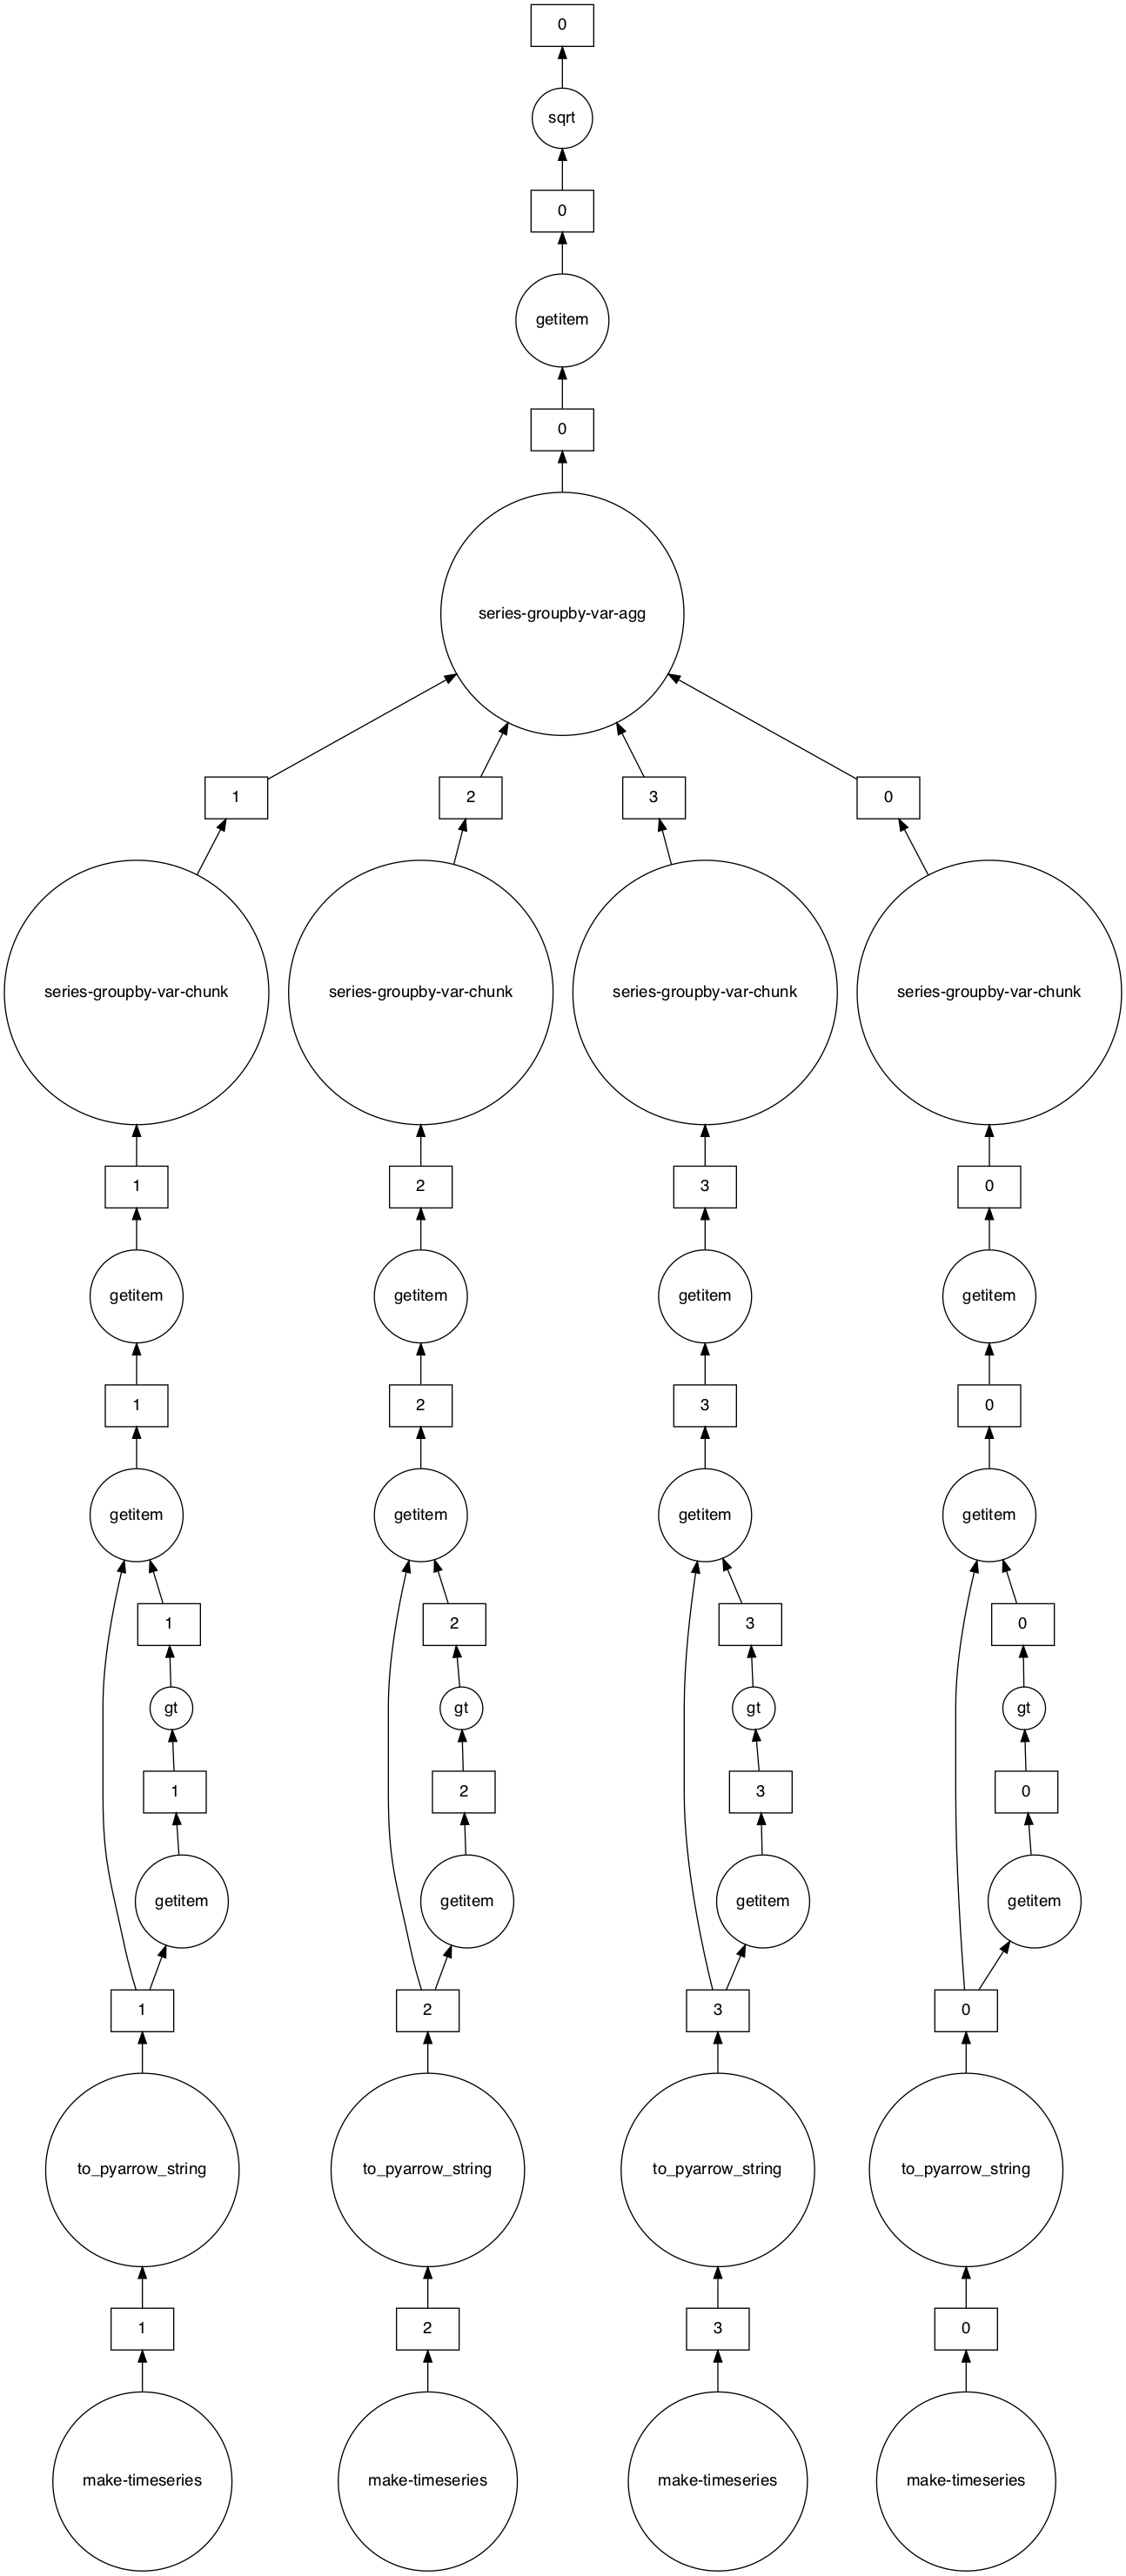

In [43]:
ddf3.visualize()

计算图中，圆圈表示计算，长方形表示数据。对于 Dask DataFrame 来说，长方形就是 pandas `DataFrame`。